In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import scipy.sparse.linalg

In [113]:
def split(X, Y, Ntrain):
    _, N = X.shape
    totalIdxs = np.arange(N)
    np.random.shuffle(totalIdxs)
    indecesTrain = totalIdxs[:Ntrain]
    indecesTest = totalIdxs[Ntrain:]
    Xtrain = X[:, indecesTrain]
    Ytrain = Y[indecesTrain]
    Xtest = X[:, indecesTest]
    Ytest = Y[indecesTest]
    return (Xtrain, Ytrain, Xtest, Ytest)

def get_centroid(X):
    return np.mean(X, axis=1)

def get_clusters(Z, Y, choosen_numbers):
  clusters = list()
  for i in choosen_numbers:
    Ii = (Y==i)
    clusters.append(Z[:,Ii])
  return clusters

def concatenation(X_set,Y_set, chosen_indexes,):
  I = []
  chosen_X = []
  chosen_Y = []

  d, N = X_set.shape
  for element in chosen_indexes:
    I.append((Y_set == element))
  
  for i in range(len(chosen_indexes)):
    chosen_X.append(X_set[:,I[i]])
    
  for i in range(len(chosen_indexes)):
    chosen_Y.append(Y_set[I[i]])

  X_conc = np.concatenate(chosen_X, axis=1)
  Y_conc = np.concatenate(chosen_Y)
  return chosen_X, chosen_Y, X_conc, Y_conc

def distances(Z,Y_conc, choosen_numbers, type):
  clusters = get_clusters(Z, Y_conc, choosen_numbers)

  centroids = []
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  
  print("Distances from centroids:")
  for j in range(len(choosen_numbers)):
    tot = 0
    for i in range(0,len(clusters[j])):
        tot = tot + np.linalg.norm(clusters[j][:,i] - centroids[j])
    dist = tot / len(clusters[j])
    print("Average distance between elements in cluster " + str(choosen_numbers[j]) + " from "+ type + " and centroid: ",str(dist))
    
def accuracy(X, Y, P, choosen_numbers, clusters, type):
  acc = 0
  centroids = []
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  print()
  print("Accuracy in classification:")
  for i in range(X.shape[1]):
    x = X[:, i]
    projected_x = P @ x
    min_dist = np.linalg.norm(projected_x - centroids[0])
    selected_cluster = choosen_numbers[0]
    for j,num in enumerate(choosen_numbers):
      if(np.linalg.norm(projected_x - centroids[j]) < min_dist):
        min_dist = np.linalg.norm(projected_x - centroids[j])
        selected_cluster = num
    if(selected_cluster == Y[i]):
      acc += 1
  print("Total test for accuracy: ", X.shape[1])
  print("Total right guess for algorithm ", type, "= ", acc)
  acc /= X.shape[1]
  print("Accuracy is: ", acc*100, "%")
  return acc*100
  


def plot(Z, Y_conc, choosen_numbers, k, limit_axes=False):
  clusters = list()
  for i in choosen_numbers:
    Ii = (Y_conc==i)
    clusters.append(Z[:,Ii])
  centroids = list()
  for cluster in clusters:
    centroids.append(get_centroid(cluster))
  if(k == 2):
    plt.scatter(Z[0,:], Z[1,:], c=Y_conc)
    if (limit_axes):
      plt.xlim(-1,1)
      plt.ylim(-1,1)
    for element in centroids:
        plt.scatter(element[0], element[1], marker="x", color='r')
    plt.show()
  elif(k == 3):
    ax = plt.axes(projection='3d')
    ax.scatter(Z[0,:], Z[1,:], Z[2,:], c=Y_conc)
    if (limit_axes):
      ax.set_xlim(-1,1)
      ax.set_ylim(-1,1)
      ax.set_zlim(-1,1)
    for element in centroids:
        ax.scatter(element[0], element[1],element[2], color='r')
    plt.show()
  else:
    pass

In [100]:
def LDA(X_set,Y_set, chosen_indexes, k):
    d, N = X_set.shape
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(X_set,Y_set, chosen_indexes)

    centroids = []
    Xcs = []
    CX = get_centroid(X_conc)

    for element in chosen_X:
        centroids.append(get_centroid(element).reshape((d,1)))
    
    for i in range(len(chosen_indexes)):
        Xcs.append(chosen_X[i] - centroids[i])

    Xw = np.concatenate(Xcs, axis=1)
    Sw = Xw @ Xw.T

    X_s = []
    for i in range(len(centroids)):
        X_s.append(np.repeat(centroids[i], chosen_X[i].shape[1], axis=1))
        
    X_ = np.concatenate(X_s, axis=1)
    X_c = X_ - CX.reshape((d, 1))
    Sb = X_c @ X_c.T

    L = []
    try: 
        L = np.linalg.cholesky(Sw)
    except:
        eps = 1e-6
        Sw = Sw + eps * np.eye(Sw.shape[0])
        L = np.linalg.cholesky(Sw)

    W = np.linalg.inv(L) @ Sb @ L
    _, W = scipy.sparse.linalg.eigs(W,k=k)
    W = np.real(W)
    Q = np.linalg.inv(L).T @ W
    Z = Q.T @ X_conc
    return Z, Q.T, Y_conc

In [96]:
def PCA(X_set, Y_set, chosen_indexes, k):
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(X_set, Y_set, chosen_indexes)
    centroid = get_centroid(X_conc)
    centroid = np.reshape(centroid, (len(centroid), 1))
    Xc = X_conc - centroid
    U, S, Vh = np.linalg.svd(Xc, full_matrices=False)
    Uk = U[:, :k]
    return Uk.T@Xc, Uk.T, Y_conc

In [97]:
data = pd.read_csv('data.csv')
print(data.head())
print("\n",data.shape)

data = np.array(data)

X = data[:, 1:]
X = X.T
Y = data[:, 0]
print("Shape of X and Y after the split:")
print(X.shape, Y.shape)
d,N = X.shape

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

(784, 35000) (784, 7000)


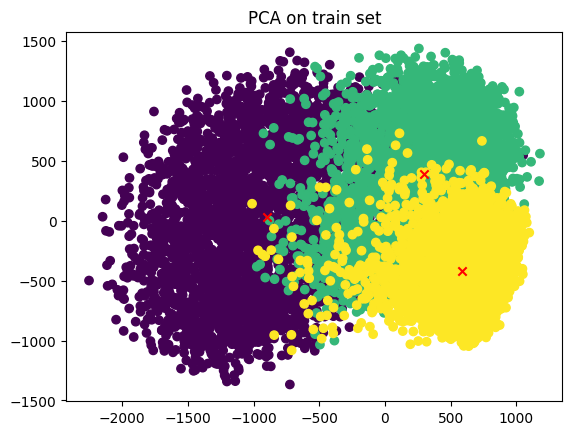

Distances from centroids:
Average distance between elements in cluster 0 from pca and centroid:  463.8039567624712
Average distance between elements in cluster 6 from pca and centroid:  346.18005084009025
Average distance between elements in cluster 9 from pca and centroid:  320.2433757965154

Accuracy in classification:
Total test for accuracy:  10346
Toatal right guess for algorithm  pca =  6554
Accuracy is:  63.34815387589406 %


In [98]:
Ntrain = 35000
Xtrain, Ytrain, Xtest, Ytest = split(X, Y, Ntrain)
print(Xtrain.shape, Xtest.shape)
chosen_indexes = [0,6,9]
k = 2
Z_pca, projection_pca, Y_conc = PCA(Xtrain, Ytrain, chosen_indexes, k)
clusters = get_clusters(Z_pca, Y_conc, chosen_indexes)

plt.title("PCA on train set")
plot(Z_pca, Y_conc, chosen_indexes, k)
distances(Z_pca, Y_conc, chosen_indexes, "pca")

chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca")


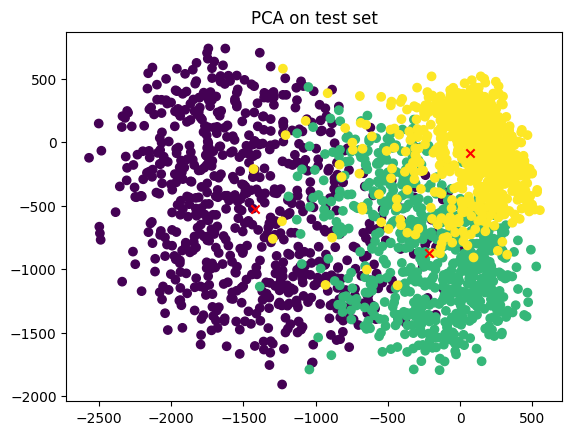

Distances from centroids:
Average distance between elements in cluster 0 from pca and centroid:  937.0172507984518
Average distance between elements in cluster 6 from pca and centroid:  761.110975709651
Average distance between elements in cluster 9 from pca and centroid:  259.4578556658049

Accuracy in classification:
Total test for accuracy:  2060
Toatal right guess for algorithm  pca =  1744
Accuracy is:  84.66019417475728 %


In [89]:
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtest, Ytest, chosen_indexes)
Ztest_pca = projection_pca @ X_conc
clusters = get_clusters(Ztest_pca, Y_conc, chosen_indexes)

plt.title("PCA on test set")
plot(Ztest_pca, Y_conc, chosen_indexes, k)

distances(Ztest_pca, Y_conc, chosen_indexes, "pca")
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca")


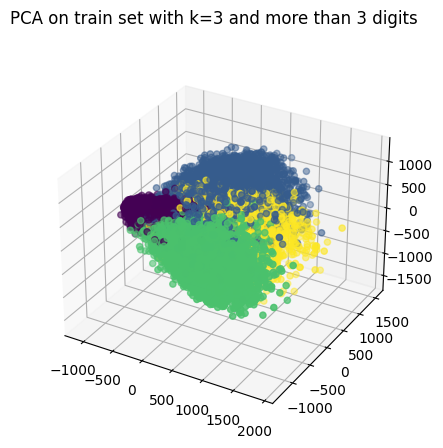

Distances from centroids:
Average distance between elements in cluster 1 from pca and centroid:  397.14888821478536
Average distance between elements in cluster 3 from pca and centroid:  534.7638001594019
Average distance between elements in cluster 6 from pca and centroid:  254.50184711706137
Average distance between elements in cluster 8 from pca and centroid:  751.3345307181474


Accuracy in classification:
Total test for accuracy:  14381
Toatal right guess for algorithm  pca =  7886
Accuracy is:  54.836242264098466 %


In [90]:
chosen_indexes = [1,3,6,8]
k = 3
Z_pca, projection_pca, Y_conc = PCA(Xtrain, Ytrain, chosen_indexes, k)

plt.suptitle("PCA on train set with k=3 and more than 3 digits")
plot(Z_pca, Y_conc, chosen_indexes, k)
clusters = get_clusters(Z_pca, Y_conc, chosen_indexes)
distances(Z_pca, Y_conc, chosen_indexes, "pca")
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
print()
accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca")


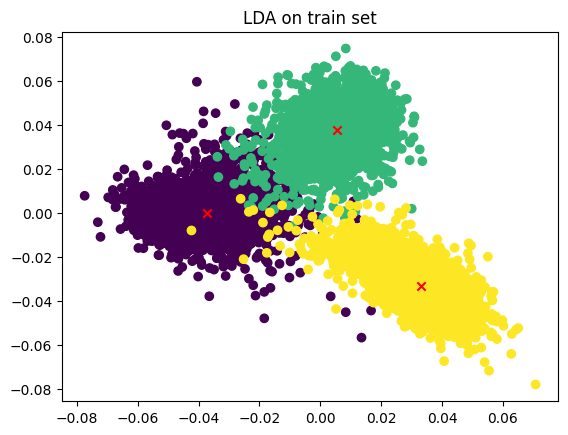

Distances from centroids:
Average distance between elements in cluster 0 from lda and centroid:  0.021845003594986107
Average distance between elements in cluster 6 from lda and centroid:  0.008540933288231734
Average distance between elements in cluster 9 from lda and centroid:  0.015166096735923012

Accuracy in classification:
Total test for accuracy:  10346
Toatal right guess for algorithm  lda =  10215
Accuracy is:  98.73381016818094 %


In [101]:
chosen_indexes = [0,6,9]
k = 2
Z_lda, projection_lda, Y_conc = LDA(Xtrain, Ytrain, chosen_indexes, k)
clusters = get_clusters(Z_lda, Y_conc, chosen_indexes)

plt.title("LDA on train set")
plot(Z_lda, Y_conc, chosen_indexes, k)

distances(Z_lda, Y_conc, chosen_indexes, "lda")
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
accuracy(X_conc, Y_conc, projection_lda, chosen_indexes, clusters, "lda")


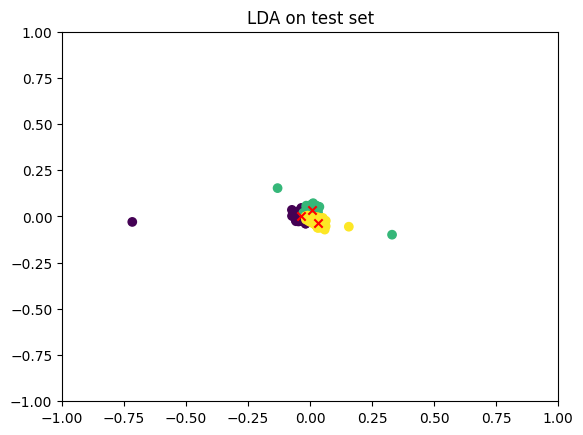

Distances from centroids:
Average distance between elements in cluster 0 from lda and centroid:  0.008267948163069888
Average distance between elements in cluster 6 from lda and centroid:  0.020270234041821968
Average distance between elements in cluster 9 from lda and centroid:  0.011306863861996638

Accuracy in classification:
Total test for accuracy:  2111
Toatal right guess for algorithm  lda =  2078
Accuracy is:  98.4367598294647 %


In [102]:
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtest, Ytest, chosen_indexes)
Ztest_lda = projection_lda @ X_conc
clusters = get_clusters(Ztest_lda, Y_conc, chosen_indexes)

plt.title("LDA on test set")
plot(Ztest_lda, Y_conc, chosen_indexes, k,limit_axes=True)

distances(Ztest_lda, Y_conc, chosen_indexes, "lda")
accuracy(X_conc, Y_conc, projection_lda, chosen_indexes, clusters, "lda")

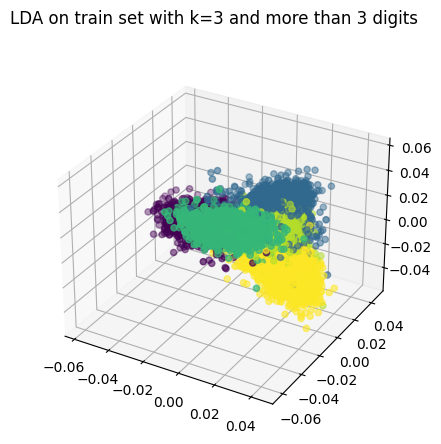

Distances from centroids:
Average distance between elements in cluster 0 from lda and centroid:  0.012298021063822237
Average distance between elements in cluster 3 from lda and centroid:  0.013186824906273237
Average distance between elements in cluster 6 from lda and centroid:  0.006401896583740678
Average distance between elements in cluster 8 from lda and centroid:  0.020591227544392802
Average distance between elements in cluster 9 from lda and centroid:  0.011309817930020295


Accuracy in classification:
Total test for accuracy:  17373
Toatal right guess for algorithm  lda =  15516
Accuracy is:  89.31099982731826 %


In [103]:
chosen_indexes = [0,3,6,8,9]
k = 3
Z_lda, projection_lda, Y_conc = LDA(Xtrain, Ytrain, chosen_indexes, k)

plt.suptitle("LDA on train set with k=3 and more than 3 digits")
plot(Z_lda, Y_conc, chosen_indexes, k)

clusters = get_clusters(Z_lda, Y_conc, chosen_indexes)
distances(Z_lda, Y_conc, chosen_indexes, "lda")
chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
print()
accuracy(X_conc, Y_conc, projection_lda, chosen_indexes, clusters, "lda")


Accuracy in classification:
Total test for accuracy:  10346
Total right guess for algorithm  lda =  9762
Accuracy is:  94.35530639860816 %

Accuracy in classification:
Total test for accuracy:  10346
Total right guess for algorithm  pca =  5520
Accuracy is:  53.35395321863522 %

Accuracy in classification:
Total test for accuracy:  10346
Total right guess for algorithm  lda =  10215
Accuracy is:  98.73381016818094 %

Accuracy in classification:
Total test for accuracy:  10346
Total right guess for algorithm  pca =  6554
Accuracy is:  63.34815387589406 %

Accuracy in classification:
Total test for accuracy:  10346
Total right guess for algorithm  lda =  10215
Accuracy is:  98.73381016818094 %

Accuracy in classification:
Total test for accuracy:  10346
Total right guess for algorithm  pca =  8493
Accuracy is:  82.08969650106322 %

Accuracy in classification:
Total test for accuracy:  10346
Total right guess for algorithm  lda =  10215
Accuracy is:  98.73381016818094 %

Accuracy in clas

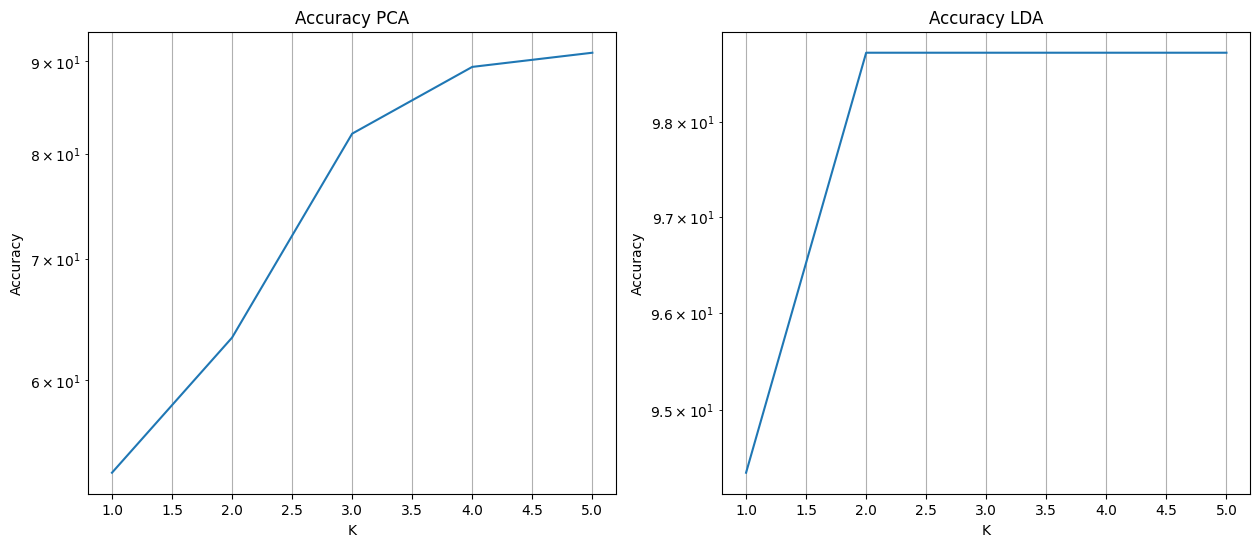

In [121]:
chosen_indexes = [0,6,9]
maxk = 6
res_pca = []
res_lda = []

for i in range(1,maxk):
    Z_lda, projection_lda, Y_conc = LDA(Xtrain, Ytrain, chosen_indexes, i)
    clusters = get_clusters(Z_lda, Y_conc, chosen_indexes)
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
    res_lda.append(accuracy(X_conc, Y_conc, projection_lda, chosen_indexes, clusters, "lda"))
    
    Z_pca, projection_pca, Y_conc = PCA(Xtrain, Ytrain, chosen_indexes, i)

    clusters = get_clusters(Z_pca, Y_conc, chosen_indexes)
    chosen_X, chosen_Y, X_conc, Y_conc = concatenation(Xtrain, Ytrain, chosen_indexes)
    res_pca.append(accuracy(X_conc, Y_conc, projection_pca, chosen_indexes, clusters, "pca"))

plt.figure(figsize=(15, 6))

ax1 = plt.subplot(1, 2, 1)
plt_x = np.arange(1,maxk)
ax1.semilogy(plt_x,res_pca)
plt.title("Accuracy PCA")
ax1.set_xlabel("K")
ax1.set_ylabel("Accuracy")

plt.grid()

ax2 = plt.subplot(1, 2, 2)
ax2.semilogy(plt_x, res_lda)
plt.title("Accuracy LDA")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("K")

plt.grid()

plt.show()
